In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

Tesla = yf.Ticker("TSLA")
df = Tesla

In [2]:
Tesla = yf.Ticker("TSLA")
df = Tesla.history(period="max")

df.to_csv("Tesla_data_for_max.csv")

print(df.head())

                               Open      High       Low     Close     Volume  \
Date                                                                           
2010-06-29 00:00:00-04:00  1.266667  1.666667  1.169333  1.592667  281494500   
2010-06-30 00:00:00-04:00  1.719333  2.028000  1.553333  1.588667  257806500   
2010-07-01 00:00:00-04:00  1.666667  1.728000  1.351333  1.464000  123282000   
2010-07-02 00:00:00-04:00  1.533333  1.540000  1.247333  1.280000   77097000   
2010-07-06 00:00:00-04:00  1.333333  1.333333  1.055333  1.074000  103003500   

                           Dividends  Stock Splits  
Date                                                
2010-06-29 00:00:00-04:00        0.0           0.0  
2010-06-30 00:00:00-04:00        0.0           0.0  
2010-07-01 00:00:00-04:00        0.0           0.0  
2010-07-02 00:00:00-04:00        0.0           0.0  
2010-07-06 00:00:00-04:00        0.0           0.0  


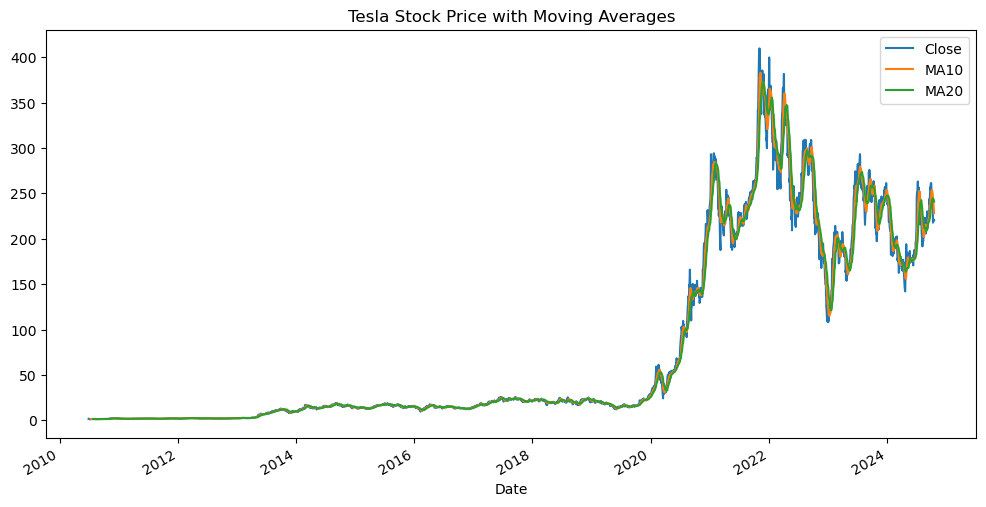

In [3]:
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df[['Close', 'MA10', 'MA20']].plot(figsize=(12, 6))
plt.title("Tesla Stock Price with Moving Averages")
plt.show()

In [4]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
    if result[1] <= 0.05:
        print("הסדרה סטציונרית")
    else:
        print("הסדרה אינה סטציונרית")

adf_test(df['Close'])

ADF Statistic: -1.1425366286605645
p-value: 0.6978142881315632
הסדרה אינה סטציונרית


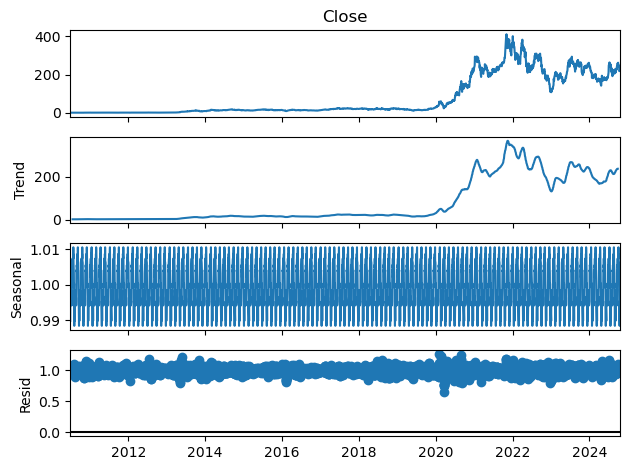

In [5]:
# decomposing של מחירי הסגירה של מניית Tesla
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
decomposition.plot()
plt.show()

In [6]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    print(out.to_string())
    
    if result[1] <= 0.05:
        print('הסדרה סטציונרית')
    else:
        print('הסדרה אינה סטציונרית')

adf_test(df['Close'])

ADF test statistic      -1.142537
p-value                  0.697814
# lags used             29.000000
# observations        3572.000000
הסדרה אינה סטציונרית


11:45:15 - cmdstanpy - INFO - Chain [1] start processing
11:45:17 - cmdstanpy - INFO - Chain [1] done processing


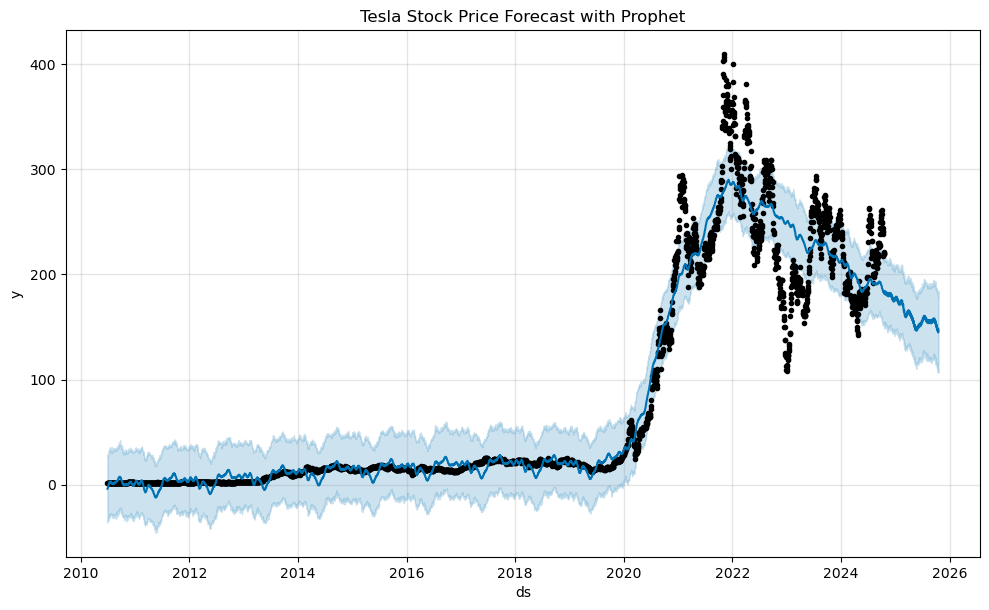

In [7]:
Tesla = yf.Ticker("TSLA")
df = Tesla.history(period="max")

df_prophet = df.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

model = Prophet()

model.fit(df_prophet)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

model.plot(forecast)
plt.title("Tesla Stock Price Forecast with Prophet")
plt.show()

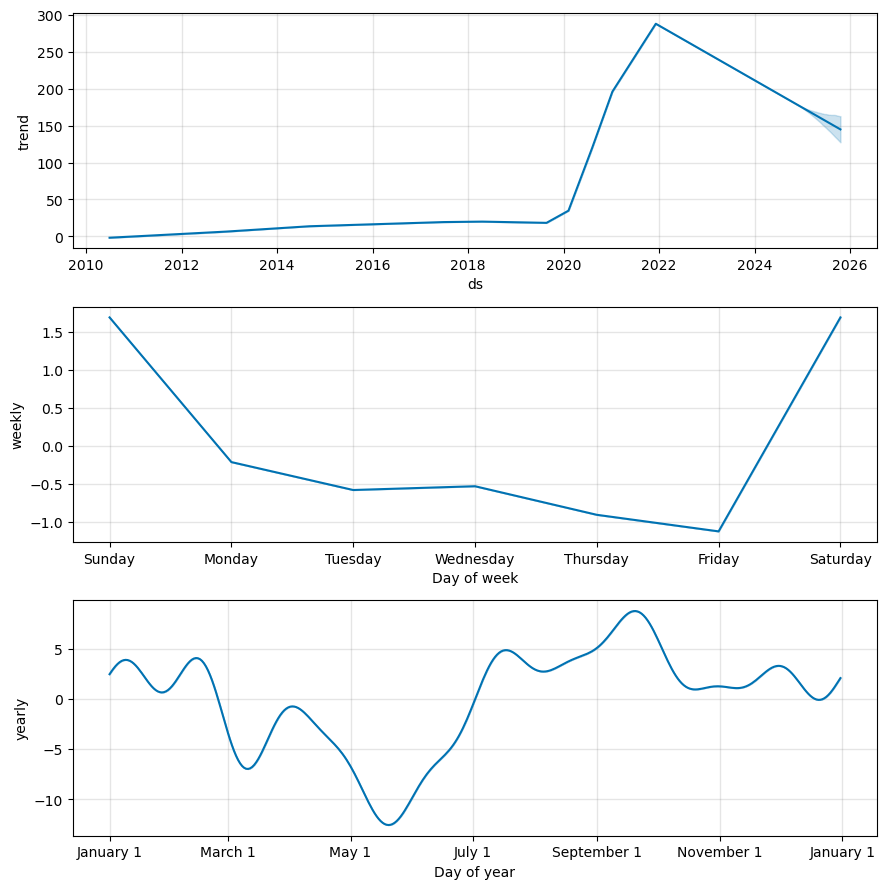

In [8]:
model.plot_components(forecast)
plt.show()

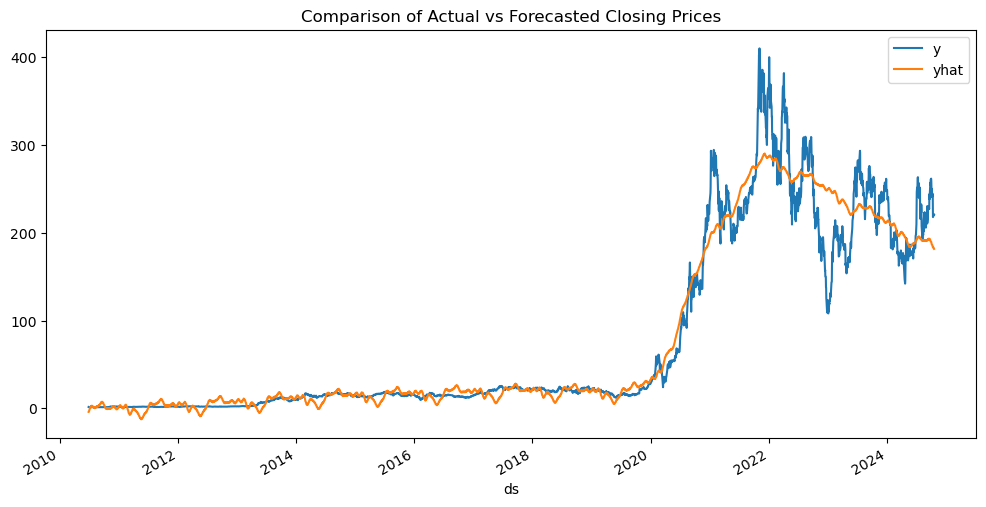

In [9]:
df_merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds')
df_merged[['ds', 'y', 'yhat']].set_index('ds').plot(figsize=(12, 6))
plt.title("Comparison of Actual vs Forecasted Closing Prices")
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# חישוב RMSE ו-MAE
y_true = df_merged['y'].values
y_pred = df_merged['yhat'].values

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 24.352084017846924
MAE: 13.704469167697681


In [12]:
!pip install pandas_ta

     ---------------------------------------- 0.0/115.1 kB ? eta -:--:--
     --- ------------------------------------ 10.2/115.1 kB ? eta -:--:--
     --- ------------------------------------ 10.2/115.1 kB ? eta -:--:--
     ------ ------------------------------ 20.5/115.1 kB 110.1 kB/s eta 0:00:01
     --------- --------------------------- 30.7/115.1 kB 131.3 kB/s eta 0:00:01
     ------------- ----------------------- 41.0/115.1 kB 164.3 kB/s eta 0:00:01
     ----------------------- ------------- 71.7/115.1 kB 245.8 kB/s eta 0:00:01
     ------------------------------------ 115.1/115.1 kB 373.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218924 sha256=125a90a236b86841152401ecc36583dbe7e354924fbf97773c48479497186dd7
  Stored in directory: c:\users\אורי בראל\appdata\local\pip\cache\wheels\7f\33\8b\50b245c5c65433cd8f5cb24ac15d97e5a3d

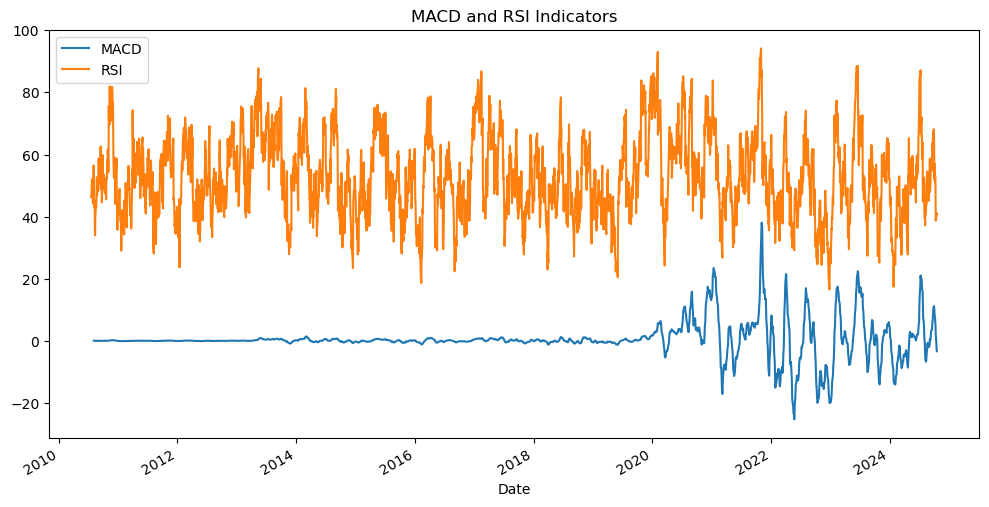

In [13]:
import pandas_ta as ta

# חישוב MACD
df['MACD'] = ta.macd(df['Close'])['MACD_12_26_9']

# חישוב RSI
df['RSI'] = ta.rsi(df['Close'], length=14)

# הצגת MACD ו-RSI
df[['MACD', 'RSI']].plot(figsize=(12, 6))
plt.title("MACD and RSI Indicators")
plt.show()

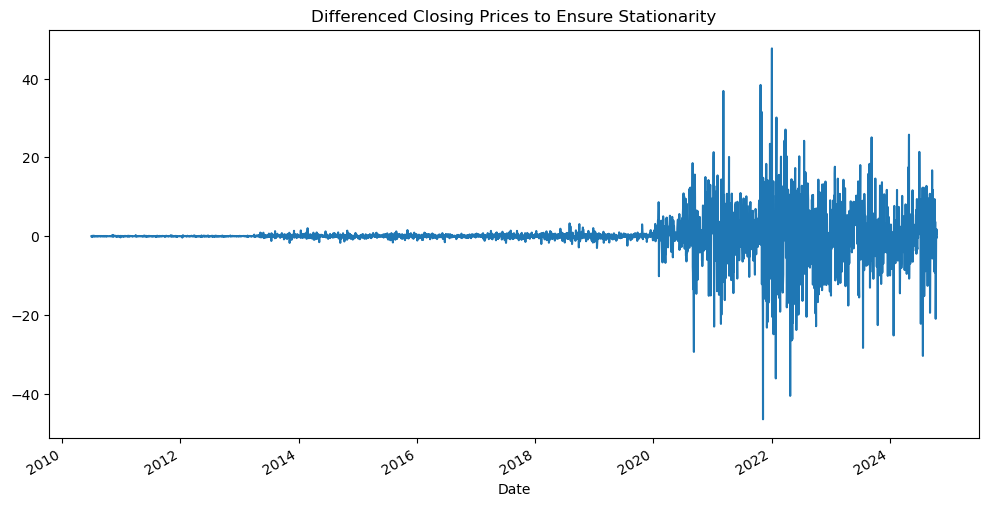

In [14]:
df['Differenced_Close'] = df['Close'].diff().dropna()
df['Differenced_Close'].plot(figsize=(12, 6))
plt.title("Differenced Closing Prices to Ensure Stationarity")
plt.show()

C:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:83

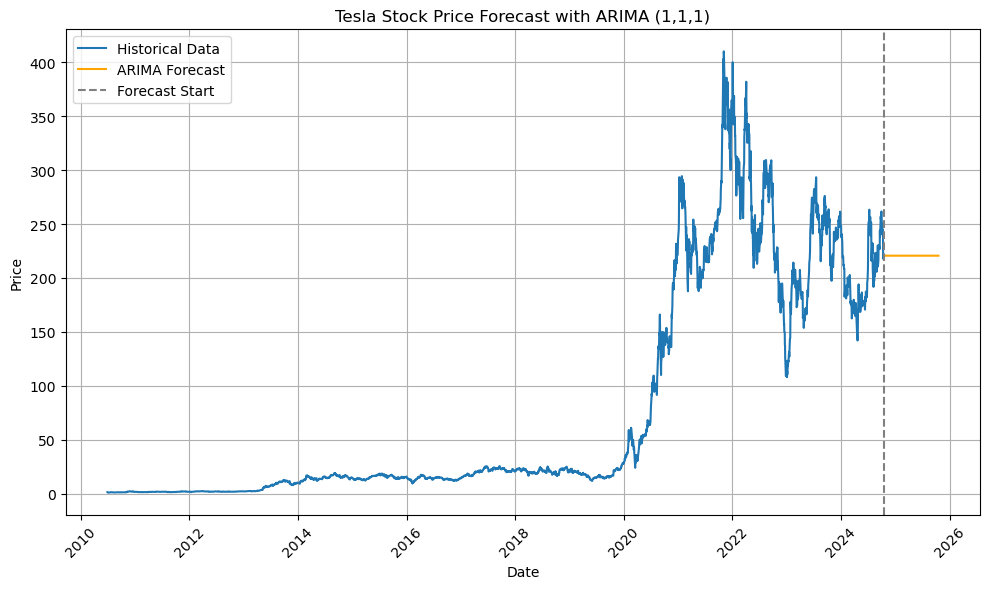

In [15]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# הכנה של נתוני ARIMA - שימוש רק בעמודת 'Close' (לדוגמה, נתוני מחירי סגירה)
df_arima = df[['Close']].copy()

# ודא שאינדקס התאריך הוא מסוג datetime
df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

# בניית מודל ARIMA עם הפרמטרים (1, 1, 1)
model_arima = ARIMA(df_arima['Close'], order=(1, 1, 1))
model_fit_arima = model_arima.fit()

# חיזוי עבור 365 הימים הבאים
forecast_steps = 365  # מספר הימים לחיזוי
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)

# יצירת טווח תאריכים עבור התחזית
future_dates = pd.date_range(start=df_arima.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# הכנת DataFrame עם התחזית
forecast_df_arima = pd.DataFrame({'Date': future_dates, 'Forecast': forecast_arima})

# הצגת התחזית על הגרף
plt.figure(figsize=(10,6))
plt.plot(df_arima.index, df_arima['Close'], label='Historical Data')
plt.plot(future_dates, forecast_arima, label='ARIMA Forecast', color='orange')

# הוספת קו אנכי שמראה את התחלת החיזוי
plt.axvline(x=df_arima.index[-1], color='gray', linestyle='--', label='Forecast Start')

# כותרת וצירים
plt.title("Tesla Stock Price Forecast with ARIMA (1,1,1)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# הצגת הגרף
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
